<a href="https://colab.research.google.com/github/LimSeunghyeon1/Pitcher_pose_estimation/blob/master/Pitcher_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn

In [ ]:
!pip3 install --upgrade torch torchvision

     |████████████████████████████████| 831.4 MB 6.4 kB/s 
     |████████████████████████████████| 22.1 MB 1.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.


In [3]:
torch.cuda.is_available()


True

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [4]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

# 모든영상에서 frame뽑기



n 번째 뽑은 후 frame n.jpg로 저장

object detection으로 pitcher만 bounding box 처리

그리고 그 bounding box 내의 이미지만 pitcher n.jpg로 저장

In [5]:
#frame_image 폴더가 없으면 폴더를 만든다
!mkdir frame_image

In [12]:
# frame 1~n.jpg 저장
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_frame(video,begin_cnt):
  cap= cv2.VideoCapture(video)
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == False:
          break

      # 디렉토리는 frame_image
      cv2.imwrite(f"frame_image/frame{begin_cnt}.jpg",frame)
      begin_cnt+=1  
  cap.release()
  cv2.destroyAllWindows()
  return begin_cnt

In [25]:
#pitcher를 detection을 하기전 pretraining data를 다운받음 (shell 코드 기반)

def pitcher_pretraining():
  !mkdir ./pretrained
  !wget -O ./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
  !wget -O ./pretrained/config_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
  !tar -xvf ./pretrained/faster*.tar.gz -C ./pretrained 
  !pwd
  !ls -lia ./pretrained/faster_rcnn_resnet50_coco_2018_01_28
  cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 

                                     './pretrained/config_graph.pbtxt')
  return cv_net
  

In [24]:
def pitcher_detection(img,cv_net):
  rows = img.shape[0]
  cols = img.shape[1]

  draw_img = img.copy()

  # 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력. Tensorflow Faster RCNN은 마지막 classification layer가 Dense가 아니여서 size를 고정할 필요는 없음.  
  cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

  cv_out = cv_net.forward()
  # 차원축소
  reduction = np.squeeze(cv_out)
  detection_output_list = reduction.tolist()
  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)


  # detection한 사람중 bounding box bottom이 가장 큰 사람의 idx
  max = 0
  bottoms = []

  # detected 된 object들을 iteration 하면서 정보 추출
  for order, detection in enumerate(detection_output_list):
      score = float(detection[2])
      class_id = int(detection[1])
      # detected된 object들의 score가 0.9 이상과 사람인 경우만 추출
      if score > 0.9 and class_id == 0:
          print("this is " +str(order)+ "th picture")
          # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
          left = detection[3] * cols
          top = detection[4] * rows
          right = detection[5] * cols
          bottom = detection[6] * rows

          # 가장  bottom 값이 큰 것을 저장

          # 리스트가 비었으면:
          if not bottoms:
            bottoms.append([left,top,right,bottom])
          # 리스트가 안 비었으면
          else:
            if bottom>bottoms[max][3]:
              bottoms.pop()
              bottoms.append([left,top,right,bottom])

          # labels_to_names_seq 딕셔너리로 class_id값을 클래스명으로 변경.
          caption = "{}: {:.4f}".format("person", score)
          print(caption)
          #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
          cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
          cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
  img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
  # 투수 bbox 작업
  print(bottoms)

  pitcher_bbx = []
  for x in bottoms[0]:
    pitcher_bbx.append(int(x))
  return pitcher_bbx  #[x_low y_low x_high y_high]

In [52]:
#pitcher_bbx를 토대로 opencv로 pitcher_frame n.jpg 만들기
! mkdir pitcher_image
def get_pitcher_img(img, pitcher_bbx,cnt):
  x_low=pitcher_bbx[0]
  y_low=pitcher_bbx[1]
  x_high=pitcher_bbx[2]
  y_high=pitcher_bbx[3]
  #cv2_imshow(img)
  new_img=img[y_low:y_high,x_low:x_high].copy()
  
  cv2.imwrite(f'pitcher_image/pitcher_frame{cnt}.jpg',new_img)
  

mkdir: cannot create directory ‘pitcher_image’: File exists


In [40]:
cv_net=pitcher_pretraining()

mkdir: cannot create directory ‘./pretrained’: File exists
--2021-10-03 15:36:12--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.69.128, 2607:f8b0:4001:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.69.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

./pretrained/faster 100%[===================>] 363.69M   217MB/s    in 1.7s    

2021-10-03 15:36:14 (217 MB/s) - ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2021-10-03 15:36:14--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.

## **Main function**

video를 input을 하고
pitcher_frame n.jpg 형태로 frame을 다 crop한다

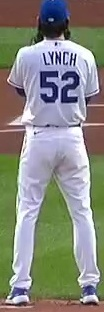

예시 pitcher_frame1.jpg


In [53]:
 from google.colab.patches import cv2_imshow
begin_cnt=0


for i in range (1,50):
  print(i)
  end_cnt=get_frame(f'original_video/fastball{i}.mp4',begin_cnt)
  for j in range(begin_cnt,end_cnt):
    img=cv2.imread(f"frame_image/frame{j}.jpg",cv2.IMREAD_COLOR)
   
    if img is None:
      print("img is none")
    pitcher_bbx=pitcher_detection(img,cv_net)
    get_pitcher_img(img,pitcher_bbx,j)

  end_cnt=begin_cnt

print("done!!")


1
this is 0th picture
person: 0.9998
this is 1th picture
person: 0.9949
this is 2th picture
person: 0.9921
this is 3th picture
person: 0.9157
this is 4th picture
person: 0.9080
[[377.8114700317383, 283.37724924087524, 481.48555755615234, 595.3698921203613]]


KeyboardInterrupt: ignored

여기 아래부터는 

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

In [ ]:
import pandas as pd
cnt=0
ankle_list=list()
#print(f"{format(cnt,'')}")
def r_file(file_dir):
  #file_dir=f"openpose/output/video_{format(cnt,'012')}_keypoints.json"
  #print(file_dir)
  #df=pd.read_json(file_dir,lines=True)
  if df is None:
    print("json file not found")
  else:
    #print(df['people'][0][2]['pose_keypoints_2d'])
    if len(df['people'][0])==1:
      cand=df['people'][0][0]['pose_keypoints_2d'][43]
      if cand !=0:
        ankle_list.append(df['people'][0][0]['pose_keypoints_2d'][43])  #x y c(confidece)
      
    elif len(df['people'][0])>1:
      temp=99999
      idx=0
      #print(df['people'][0][0])
      for i in range(0,len(df['people'][0])):
        cand=df['people'][0][i]['pose_keypoints_2d'][42]
        #print(cand)
        if min(temp,cand)==cand and cand!=0:
          temp=cand
          idx=i
      ankle_list.append(df['people'][0][idx]['pose_keypoints_2d'][43])
    else:
      print("no humans found")
    
token=0
'''
while 1:
  print(cnt)
  file_dir=f"openpose/output/video_{format(cnt,'012')}_keypoints.json"
  try :
    df=pd.read_json(file_dir,lines=True)
     
  except ValueError:
    print("All done.")
    break 
  else:
    df=pd.read_json(file_dir,lines=True)
    r_file(file_dir)
  cnt+=1
print(len(ankle_list))
'''

'\nwhile 1:\n  print(cnt)\n  file_dir=f"openpose/output/video_{format(cnt,\'012\')}_keypoints.json"\n  try :\n    df=pd.read_json(file_dir,lines=True)\n     \n  except ValueError:\n    print("All done.")\n    break \n  else:\n    df=pd.read_json(file_dir,lines=True)\n    r_file(file_dir)\n  cnt+=1\nprint(len(ankle_list))\n'

In [ ]:
#shell script 불러오는 코드
import pandas as pd
for c in range (1,51):
  input_file=f"/content/dataset/fastaball{c}.mp4"
  ouput_file=f"/content/output/output{c}.mp4"
  ! rm -rf /content/video.mp4
  ! ffmpeg -i $input_file -filter:v "crop=380:540:320:180" /content/video.mp4
  ! -filter:v "crop=380:540:320:180" /content/video.mp4
  ! rm -rf /content/openpose.avi
  ! cd /content/openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
  ! ffmpeg -y -loglevel info -i /content/openpose.avi $output_file 
  show_local_mp4_video(f'output{c}.mp4',width=960,height=720)
  while 1:
    print(cnt)
  file_dir=f"openpose/output/video_{format(cnt,'012')}_keypoints.json"
  try :
    df=pd.read_json(file_dir,lines=True)
     
  except ValueError:
    print("All done.")
    break 
  else:
    df=pd.read_json(file_dir,lines=True)
    r_file(file_dir)
    
  
  
  



ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

FileNotFoundError: ignored

In [ ]:
!ls

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
#나중에 tippint point frame 찾는 코드
def find_frame(cnt, dir):
  token=0
  video=cv2.VideoCapture(dir) # output d.mp4
  if video is None:
    print("no video")
  while True:
    ret,frame=video.read()
    if token==cnt:
      cv2_imshow(frame)
      cv2.waitkey()
      cv2.destroyAllWindows()

    if not ret:
      break
    token+=1



json 파일 구조는 다음과 같다.
pose_keypoints_2d: 몸체 위치가 x1, y1, c1, x2, y2, c2,... 와 같이 배열로 저장됨. x, y는 픽셀위치이나 0 ~ 1, -1 ~ 0 과 같이 정규화될 수 있음(keypoint_scale 옵션에 따라). c는 신뢰도로 0 ~ 1 사이값.
참고로, 각 키포인트 배열 위치 의미는 다음과 같다. 이 형식을 BODY_25 구조라 한다(참고 - OpenPose Demo Output).
//     {0,  "Nose"},//     {1,  "Neck"},//     {2,  "RShoulder"},//     {3,  "RElbow"},//     {4,  "RWrist"},//     {5,  "LShoulder"},//     {6,  "LElbow"},//     {7,  "LWrist"},//     {8,  "MidHip"},//     {9,  "RHip"},//     {10, "RKnee"},//     {11, "RAnkle"},//     {12, "LHip"},//     {13, "LKnee"},//     {14, "LAnkle"},//     {15, "REye"},//     {16, "LEye"},//     {17, "REar"},//     {18, "LEar"},//     {19, "LBigToe"},//     {20, "LSmallToe"},//     {21, "LHeel"},//     {22, "RBigToe"},//     {23, "RSmallToe"},//     {24, "RHeel"},//     {25, "Background"}

![image.png](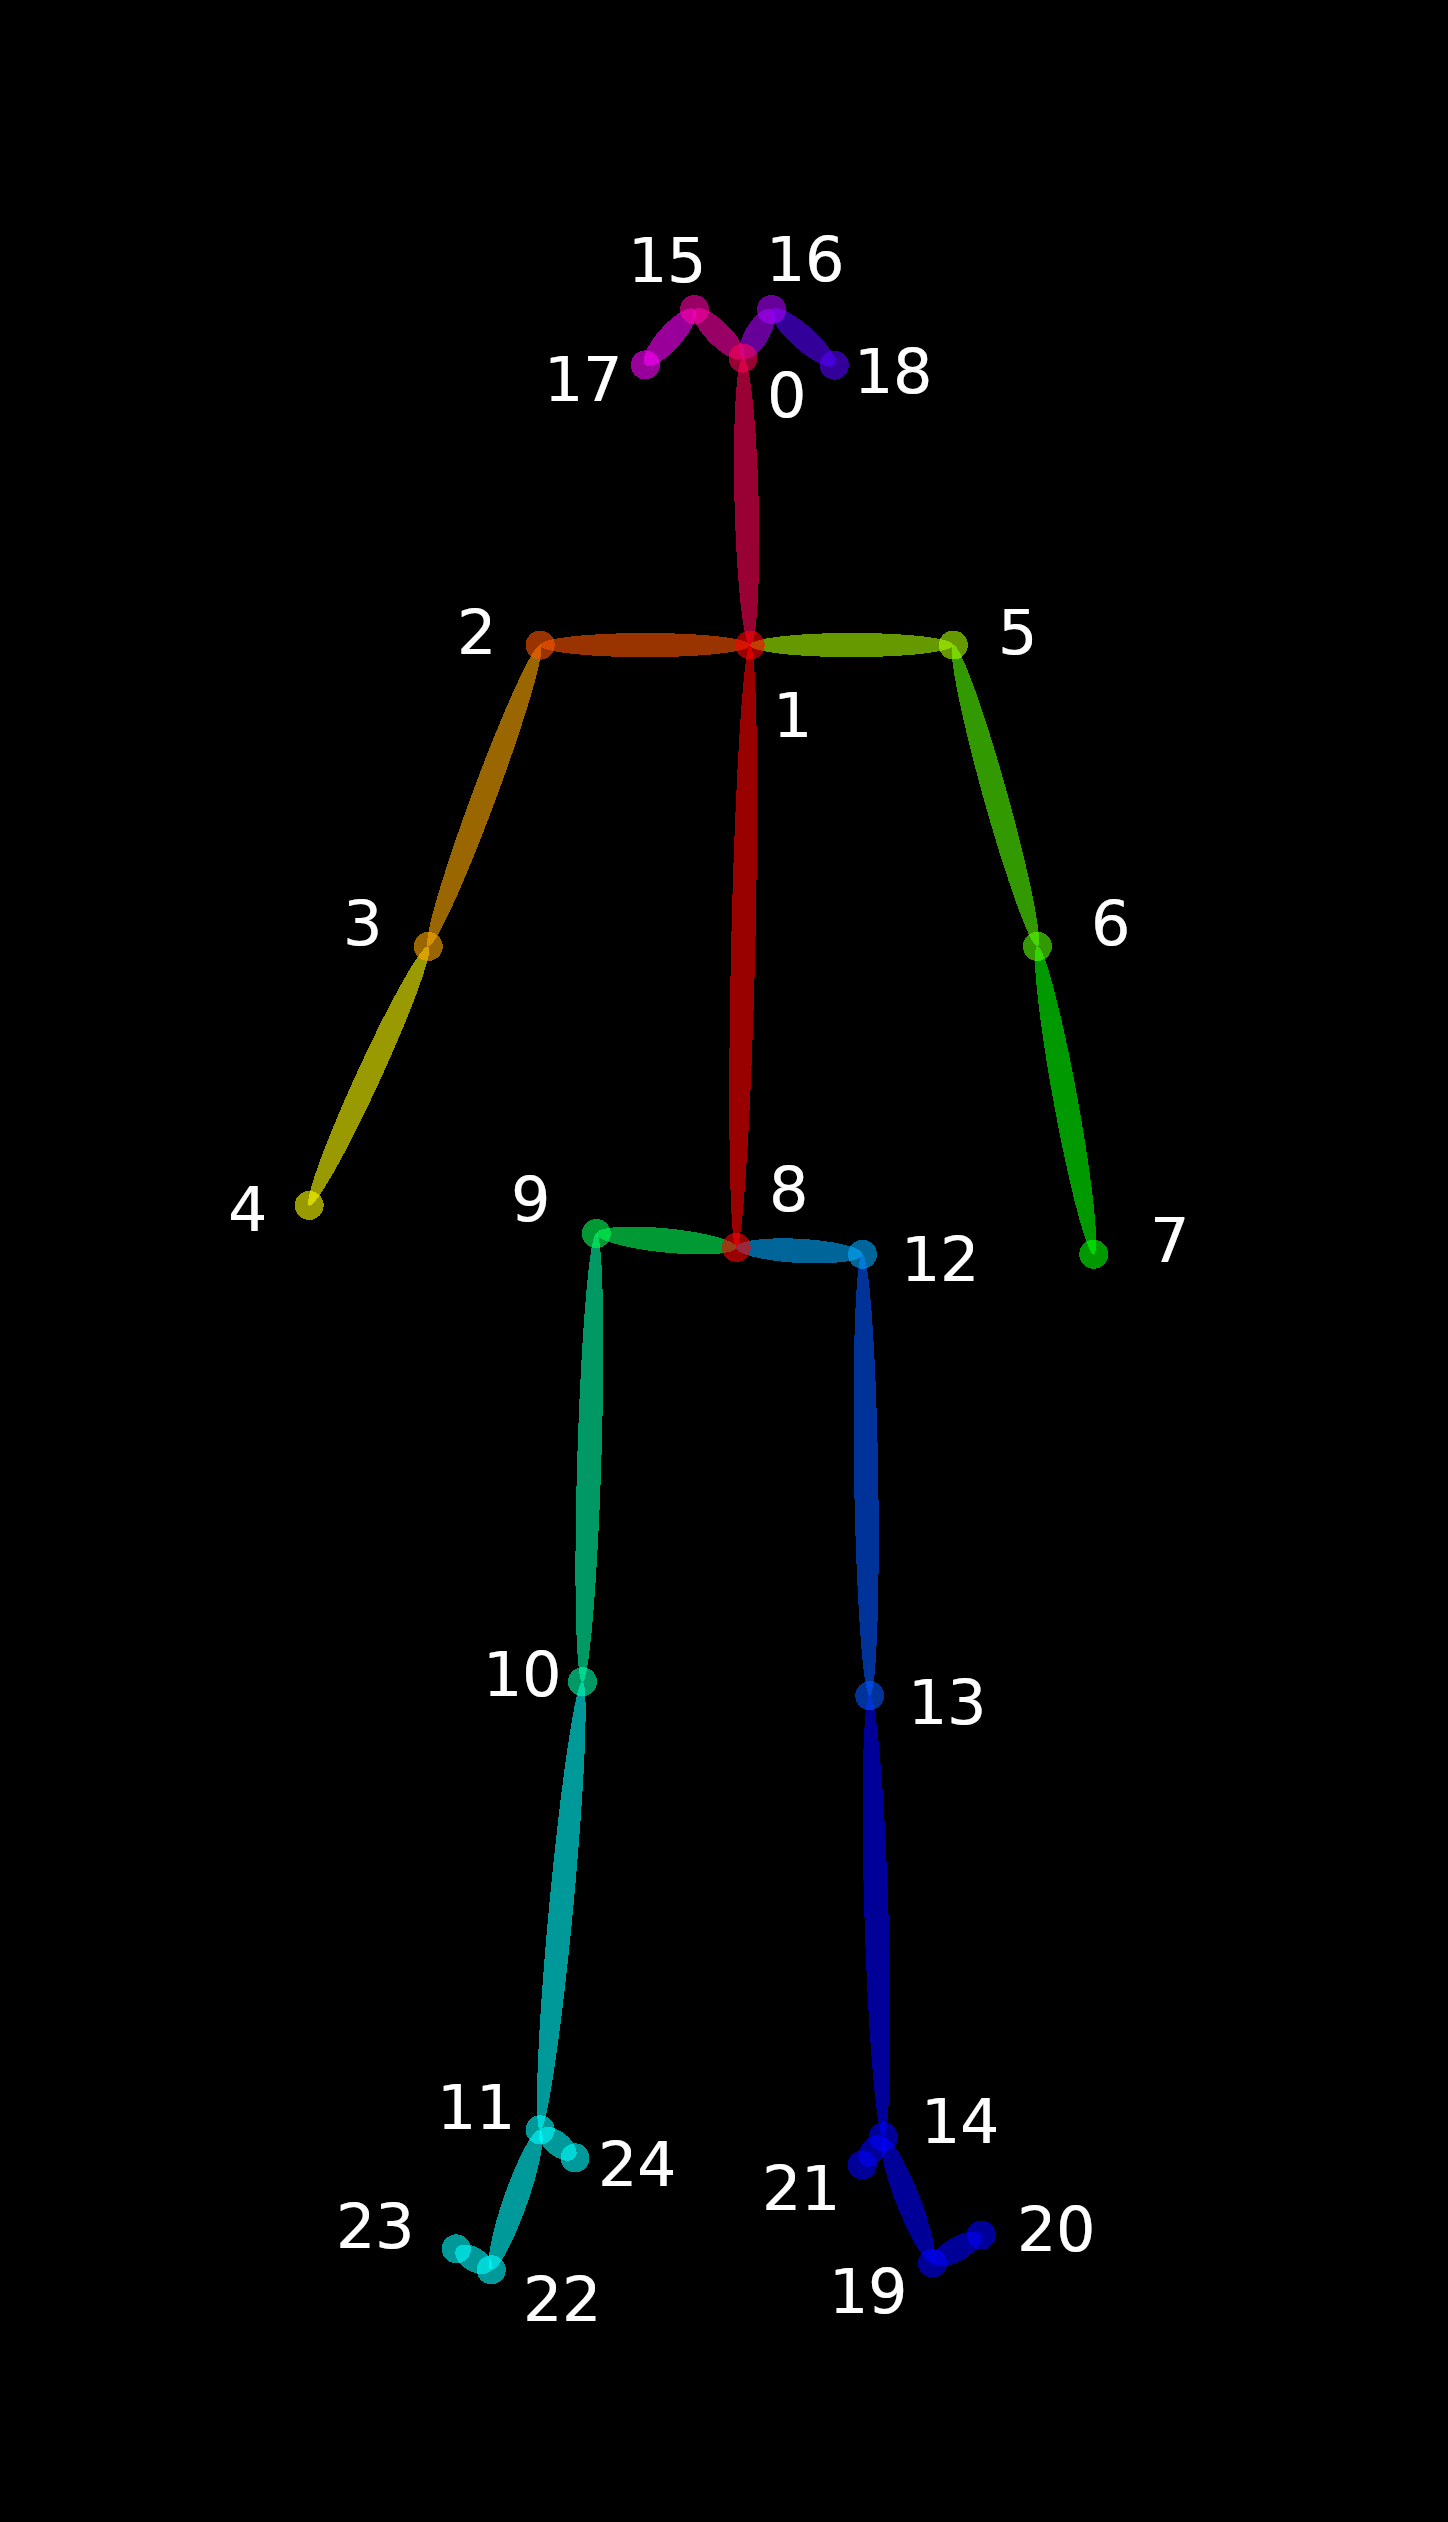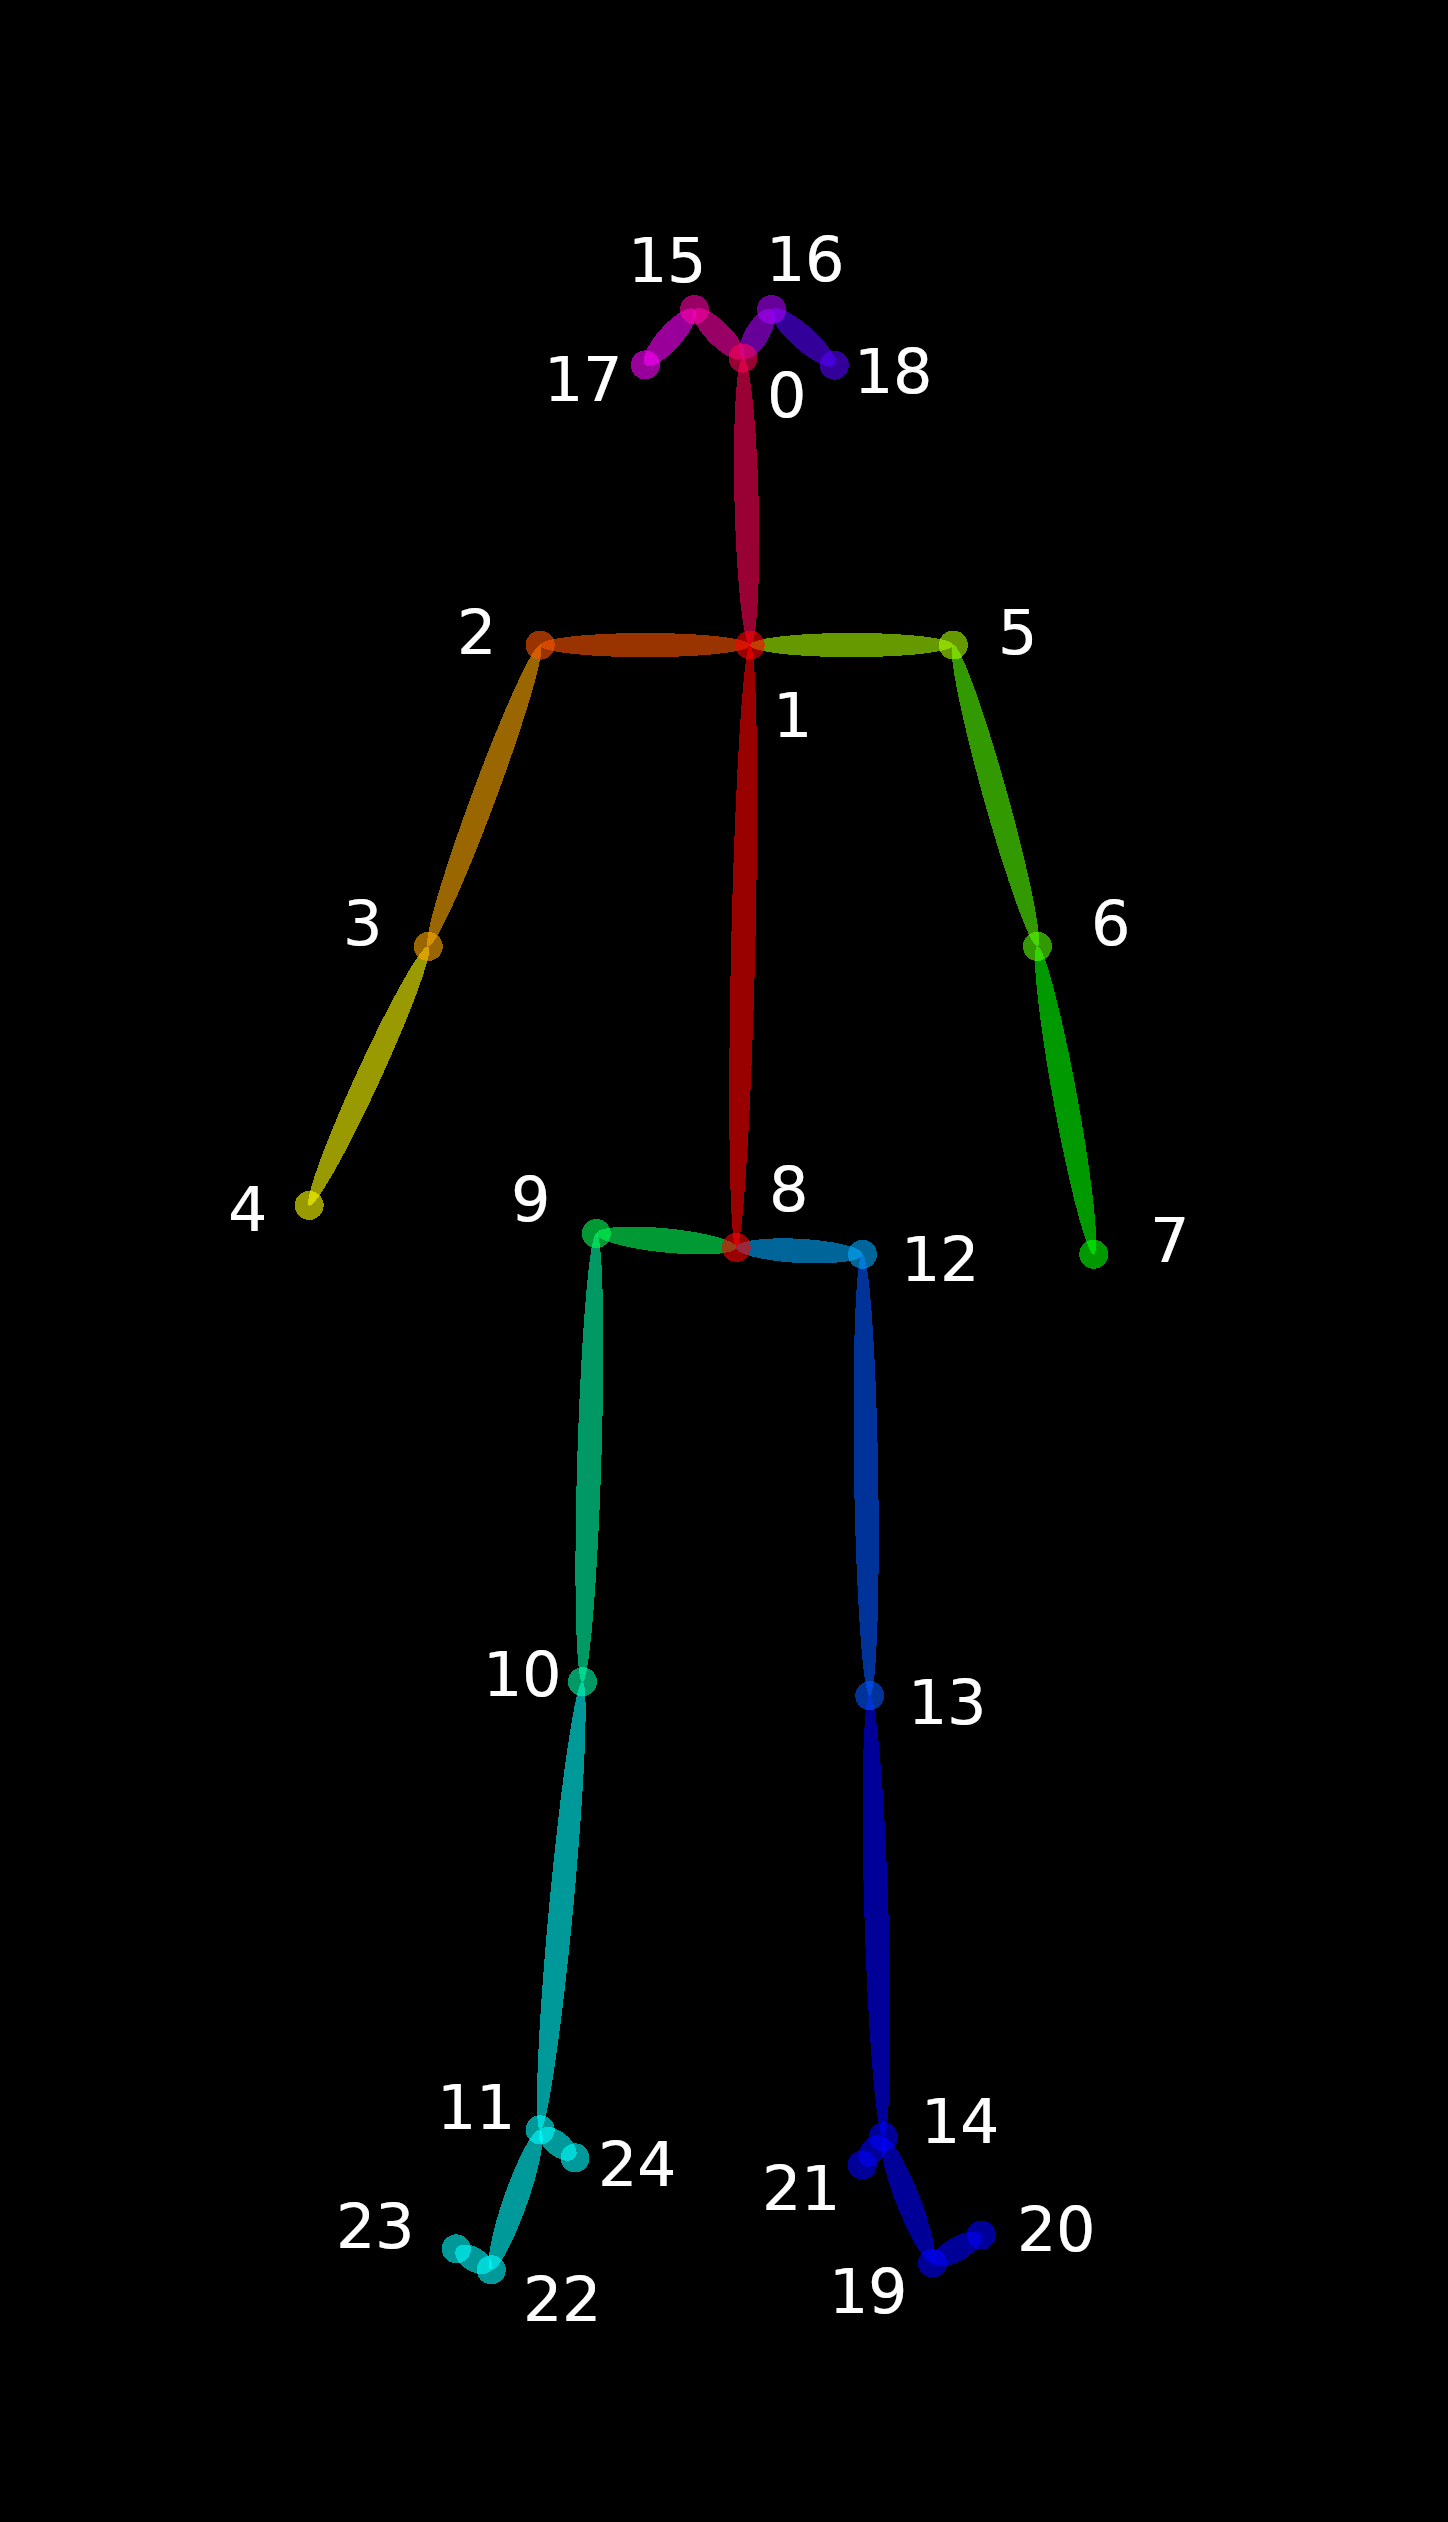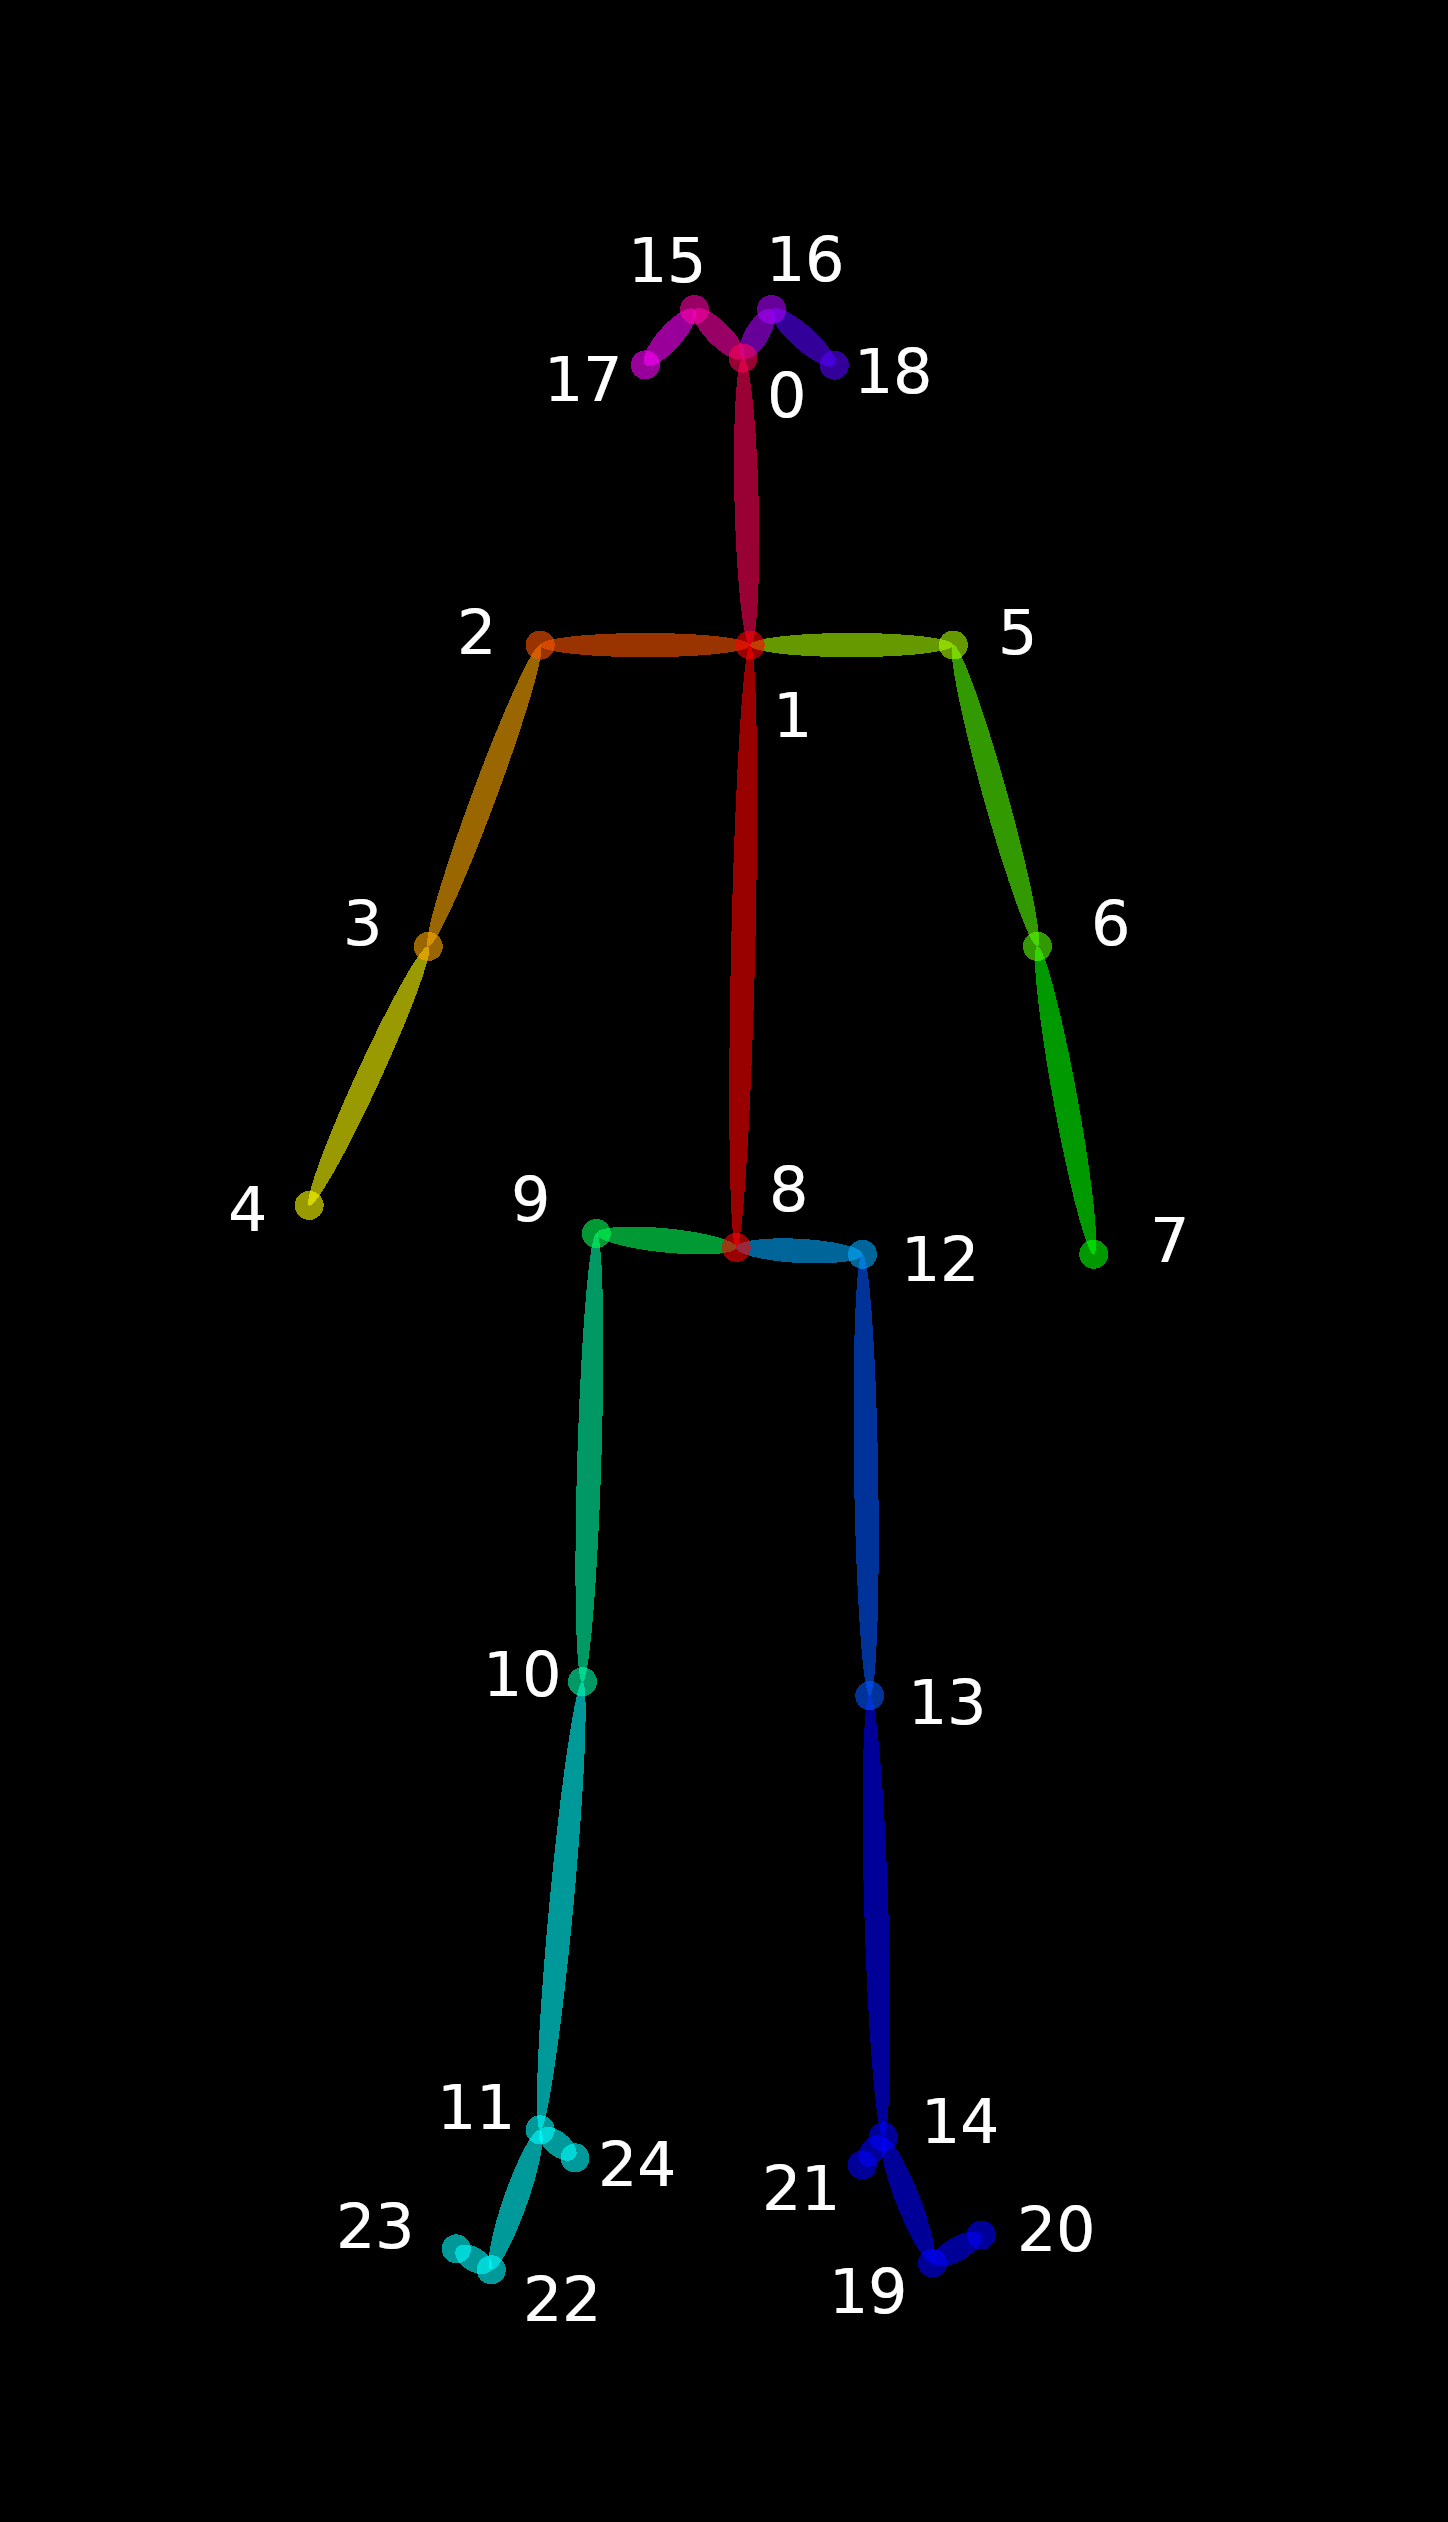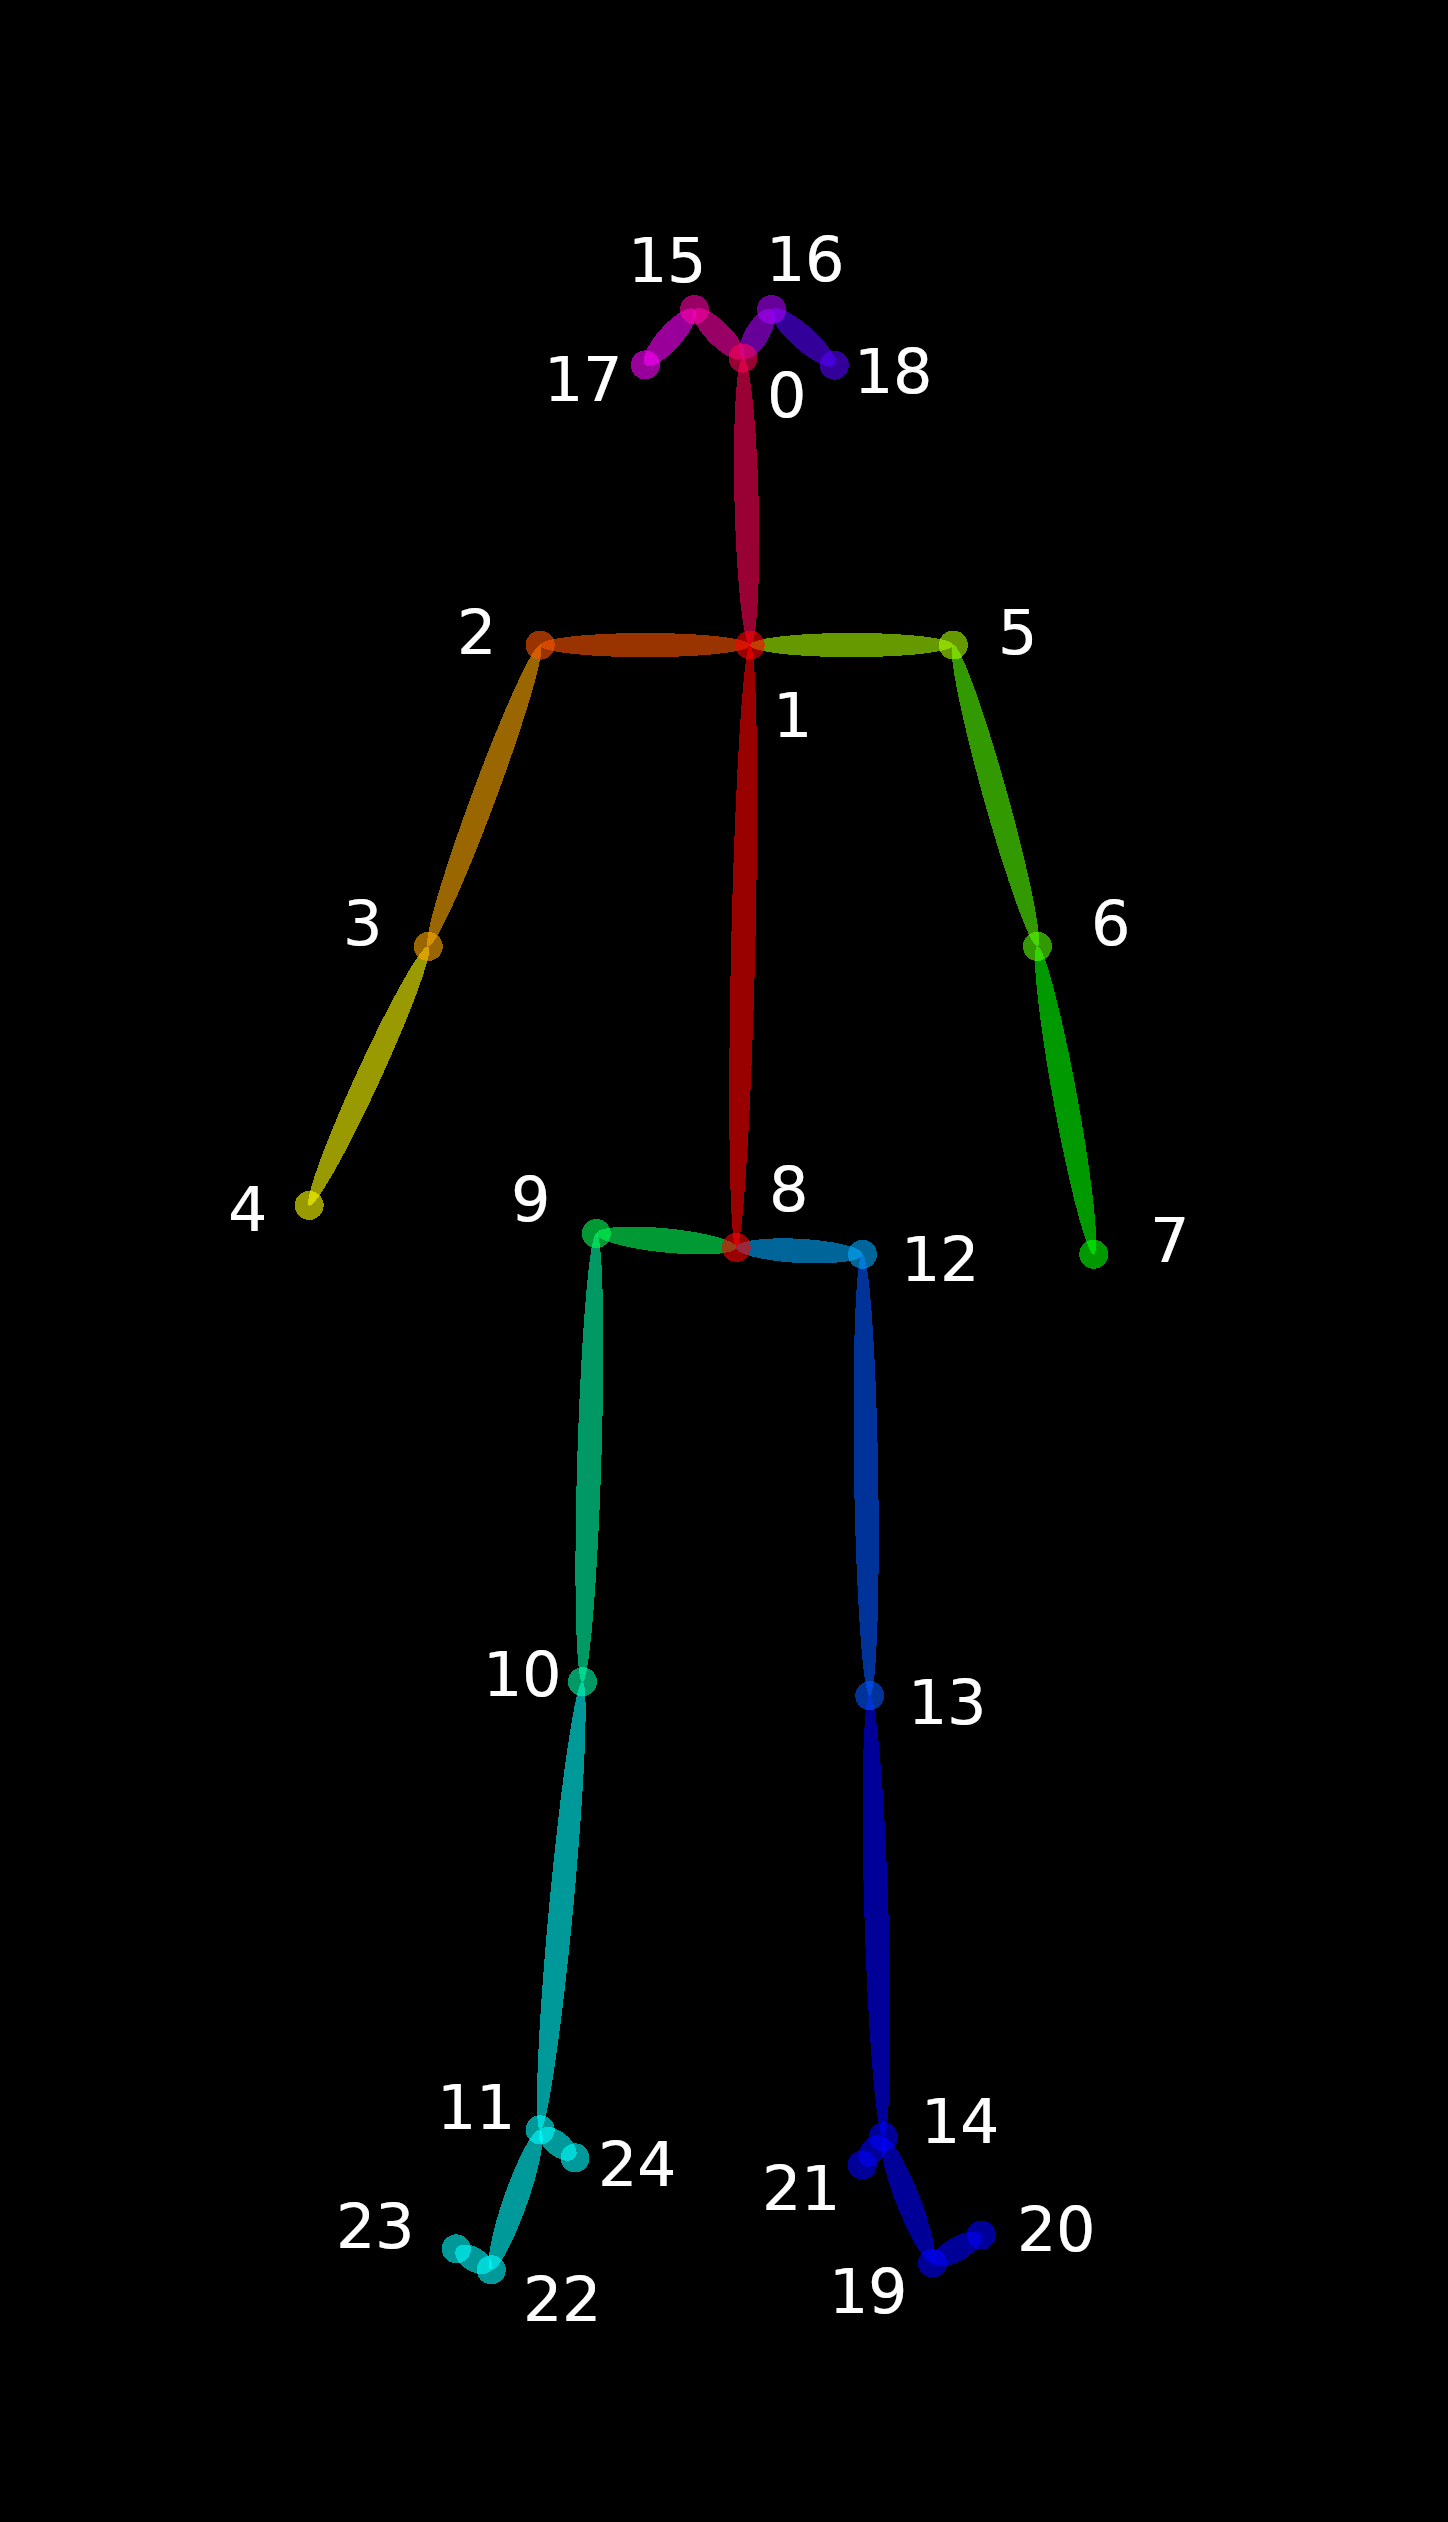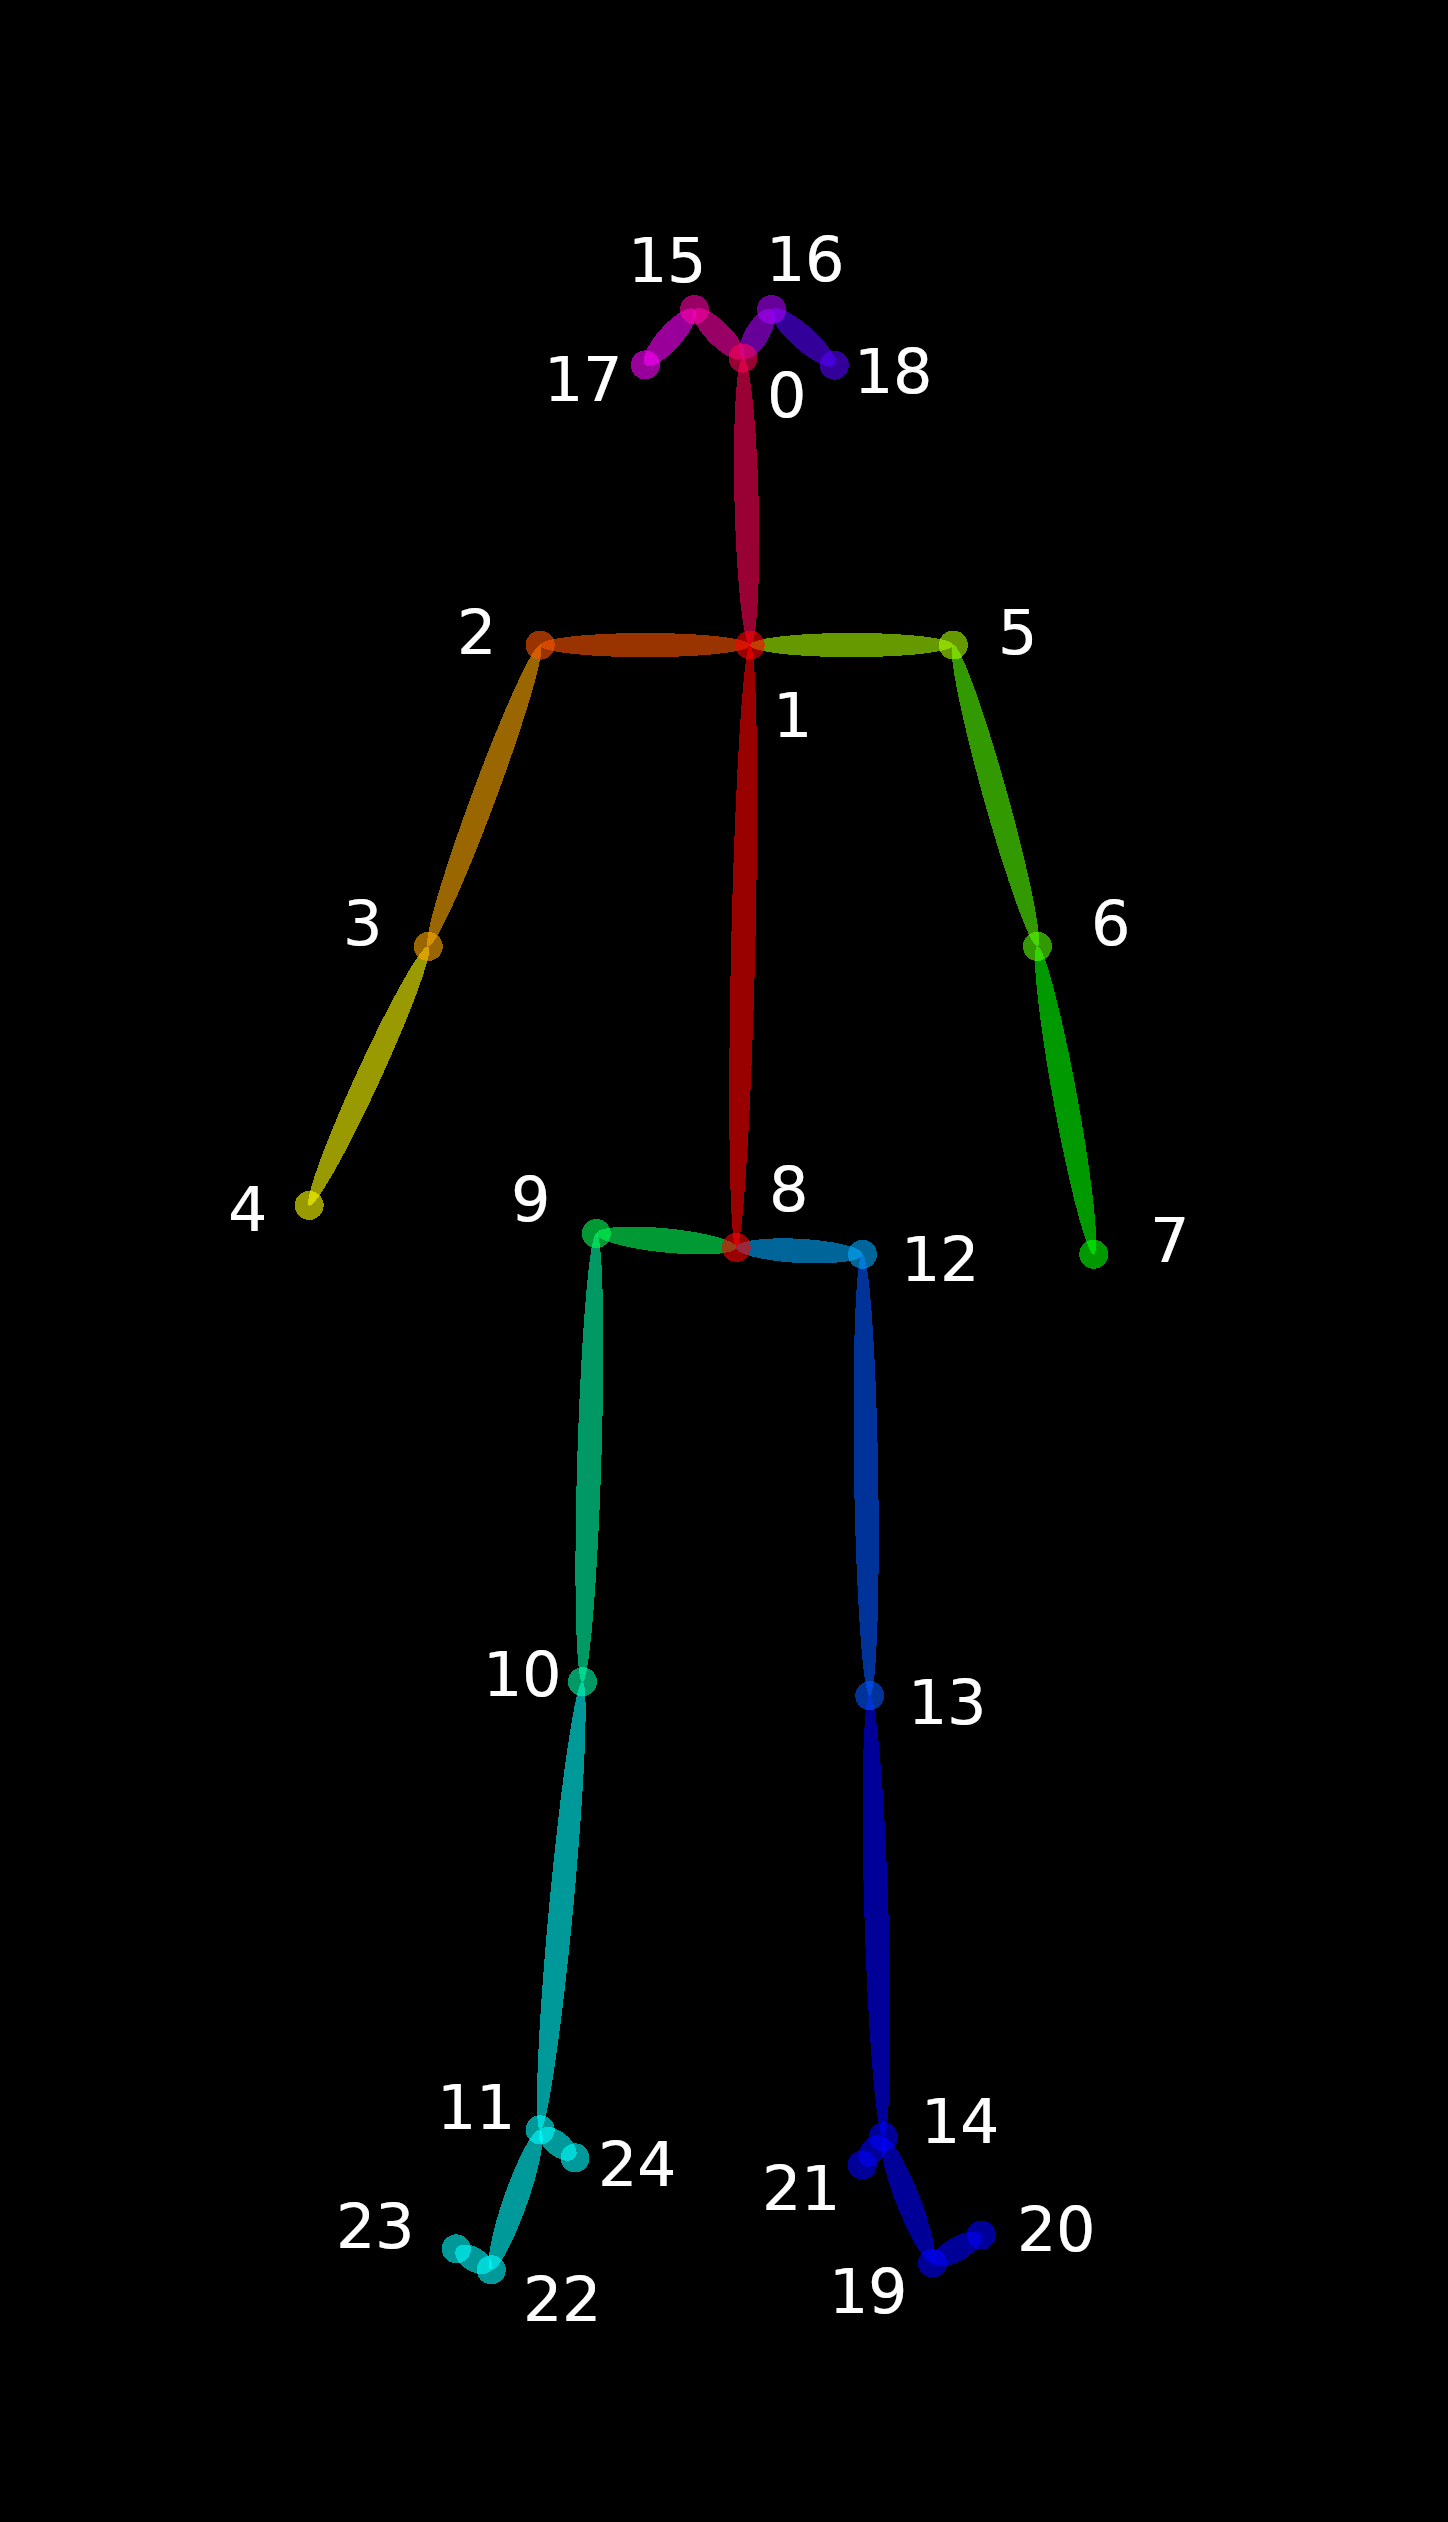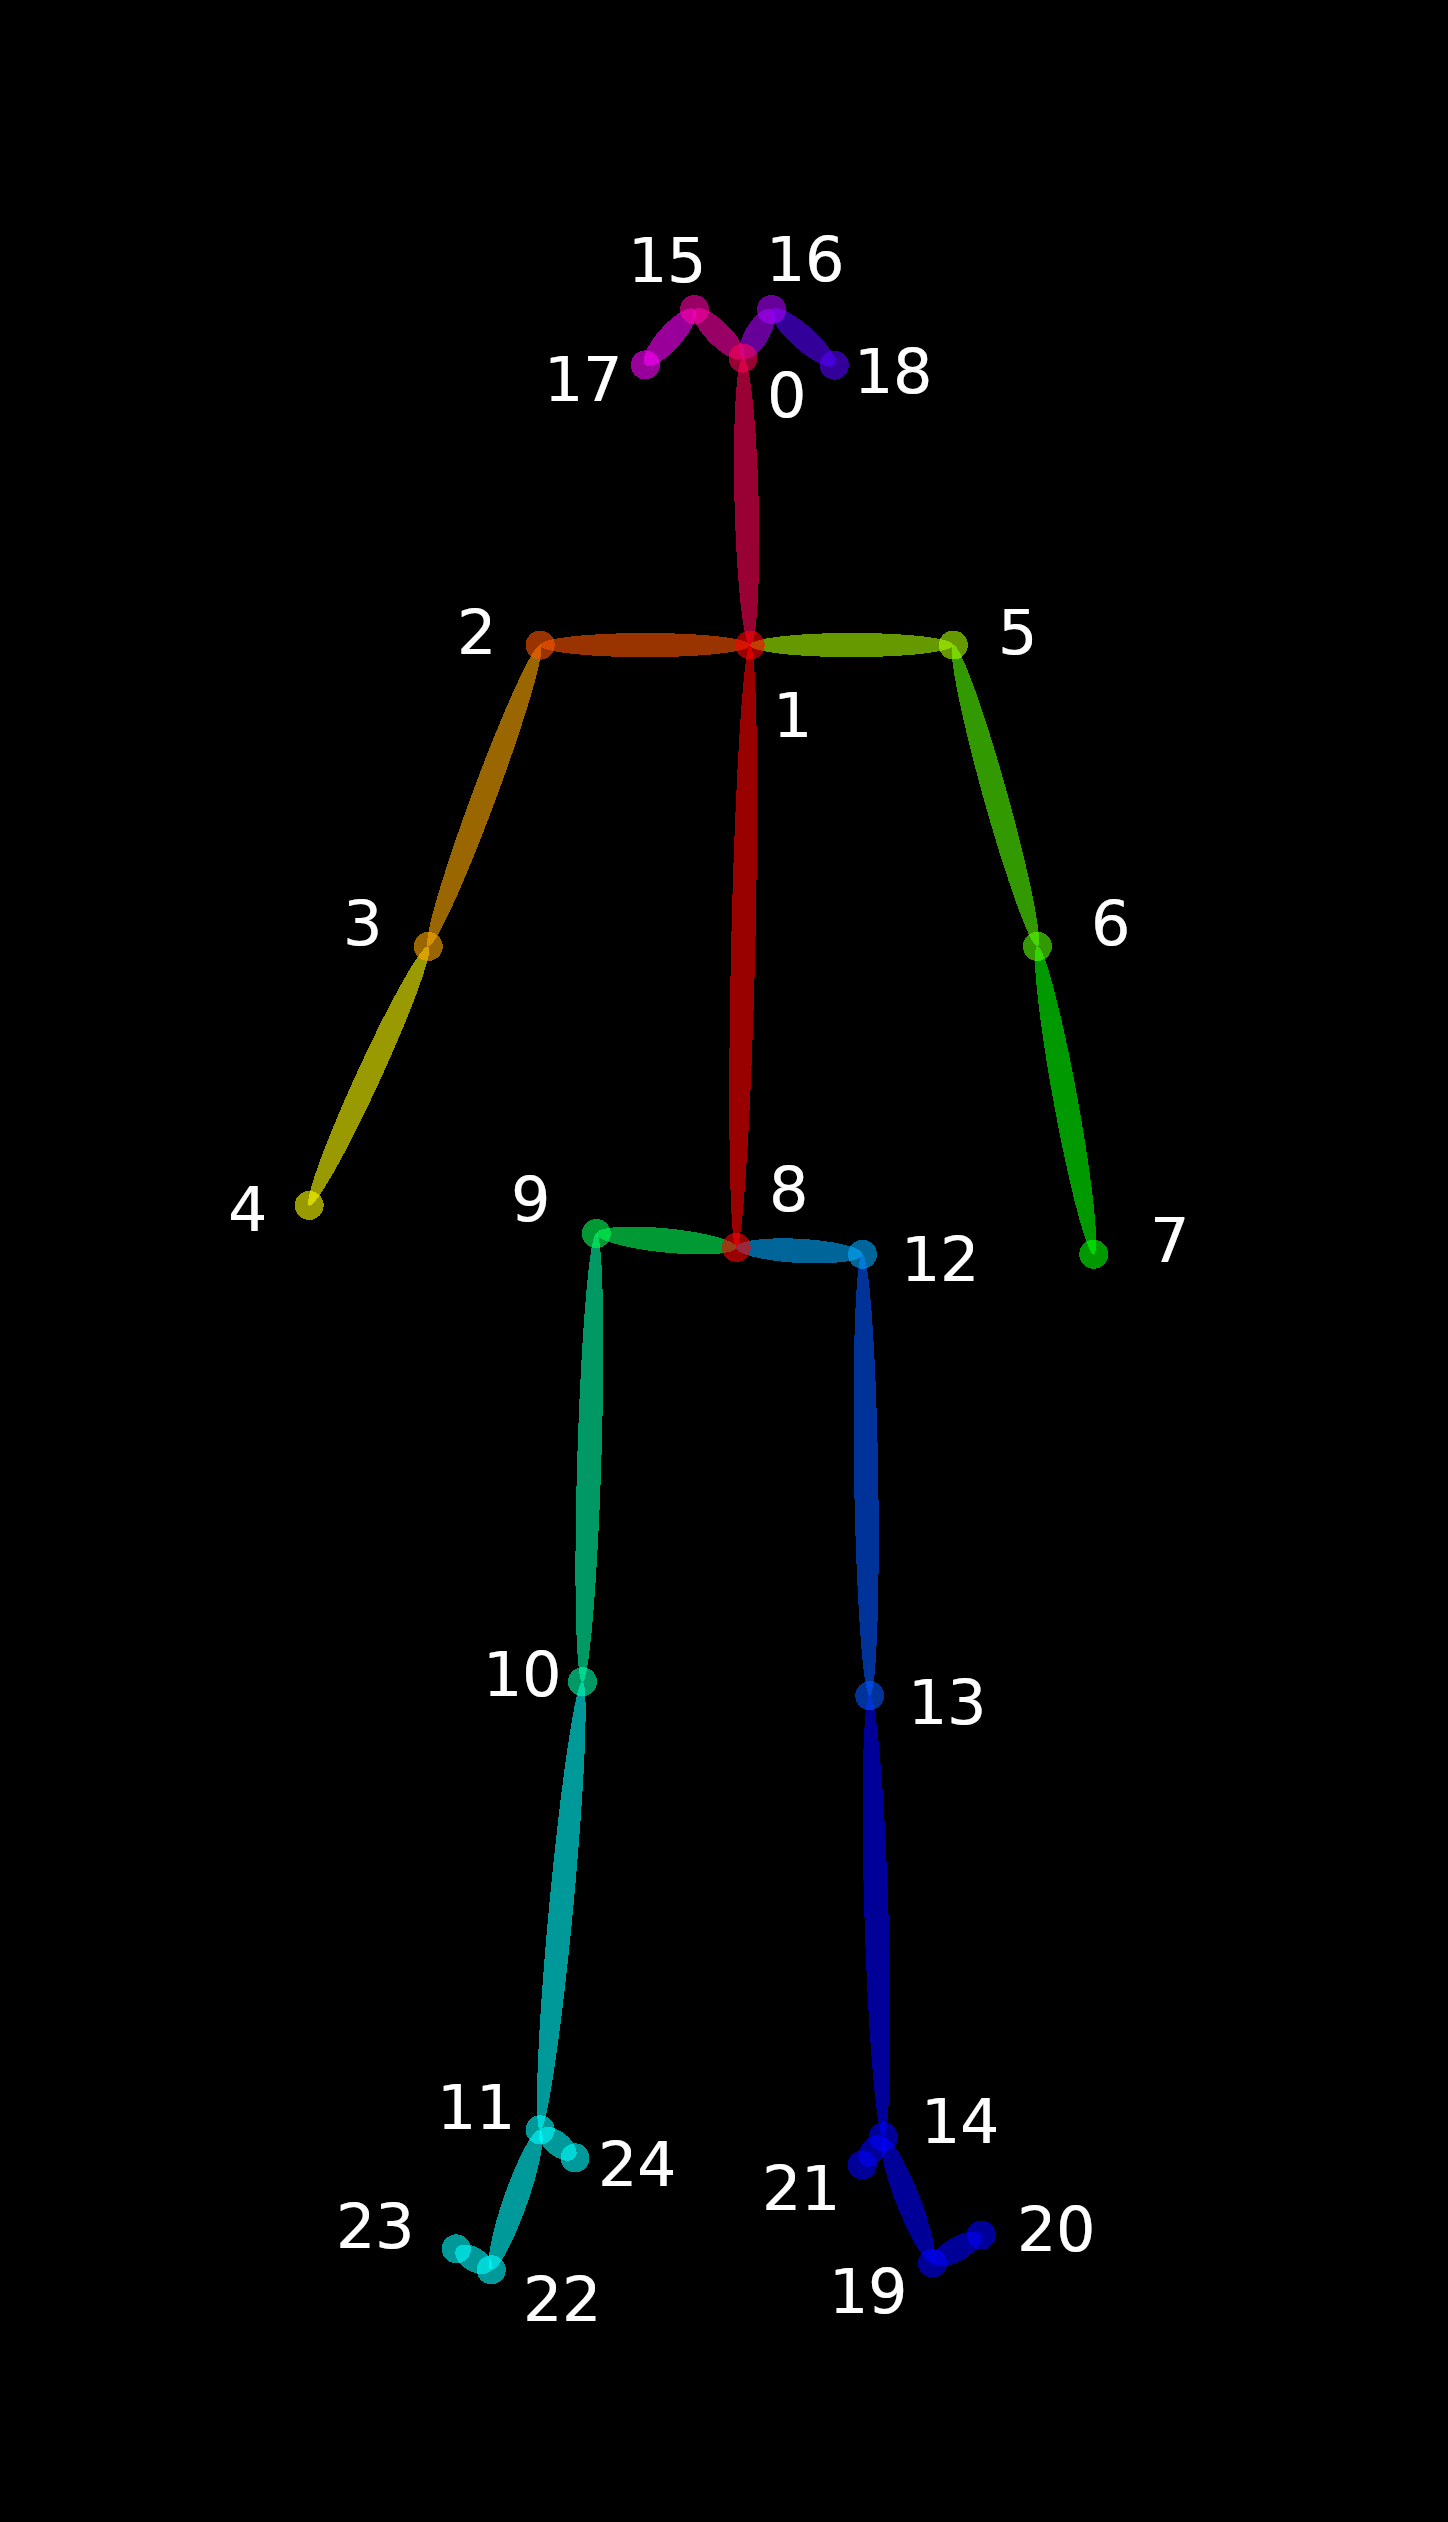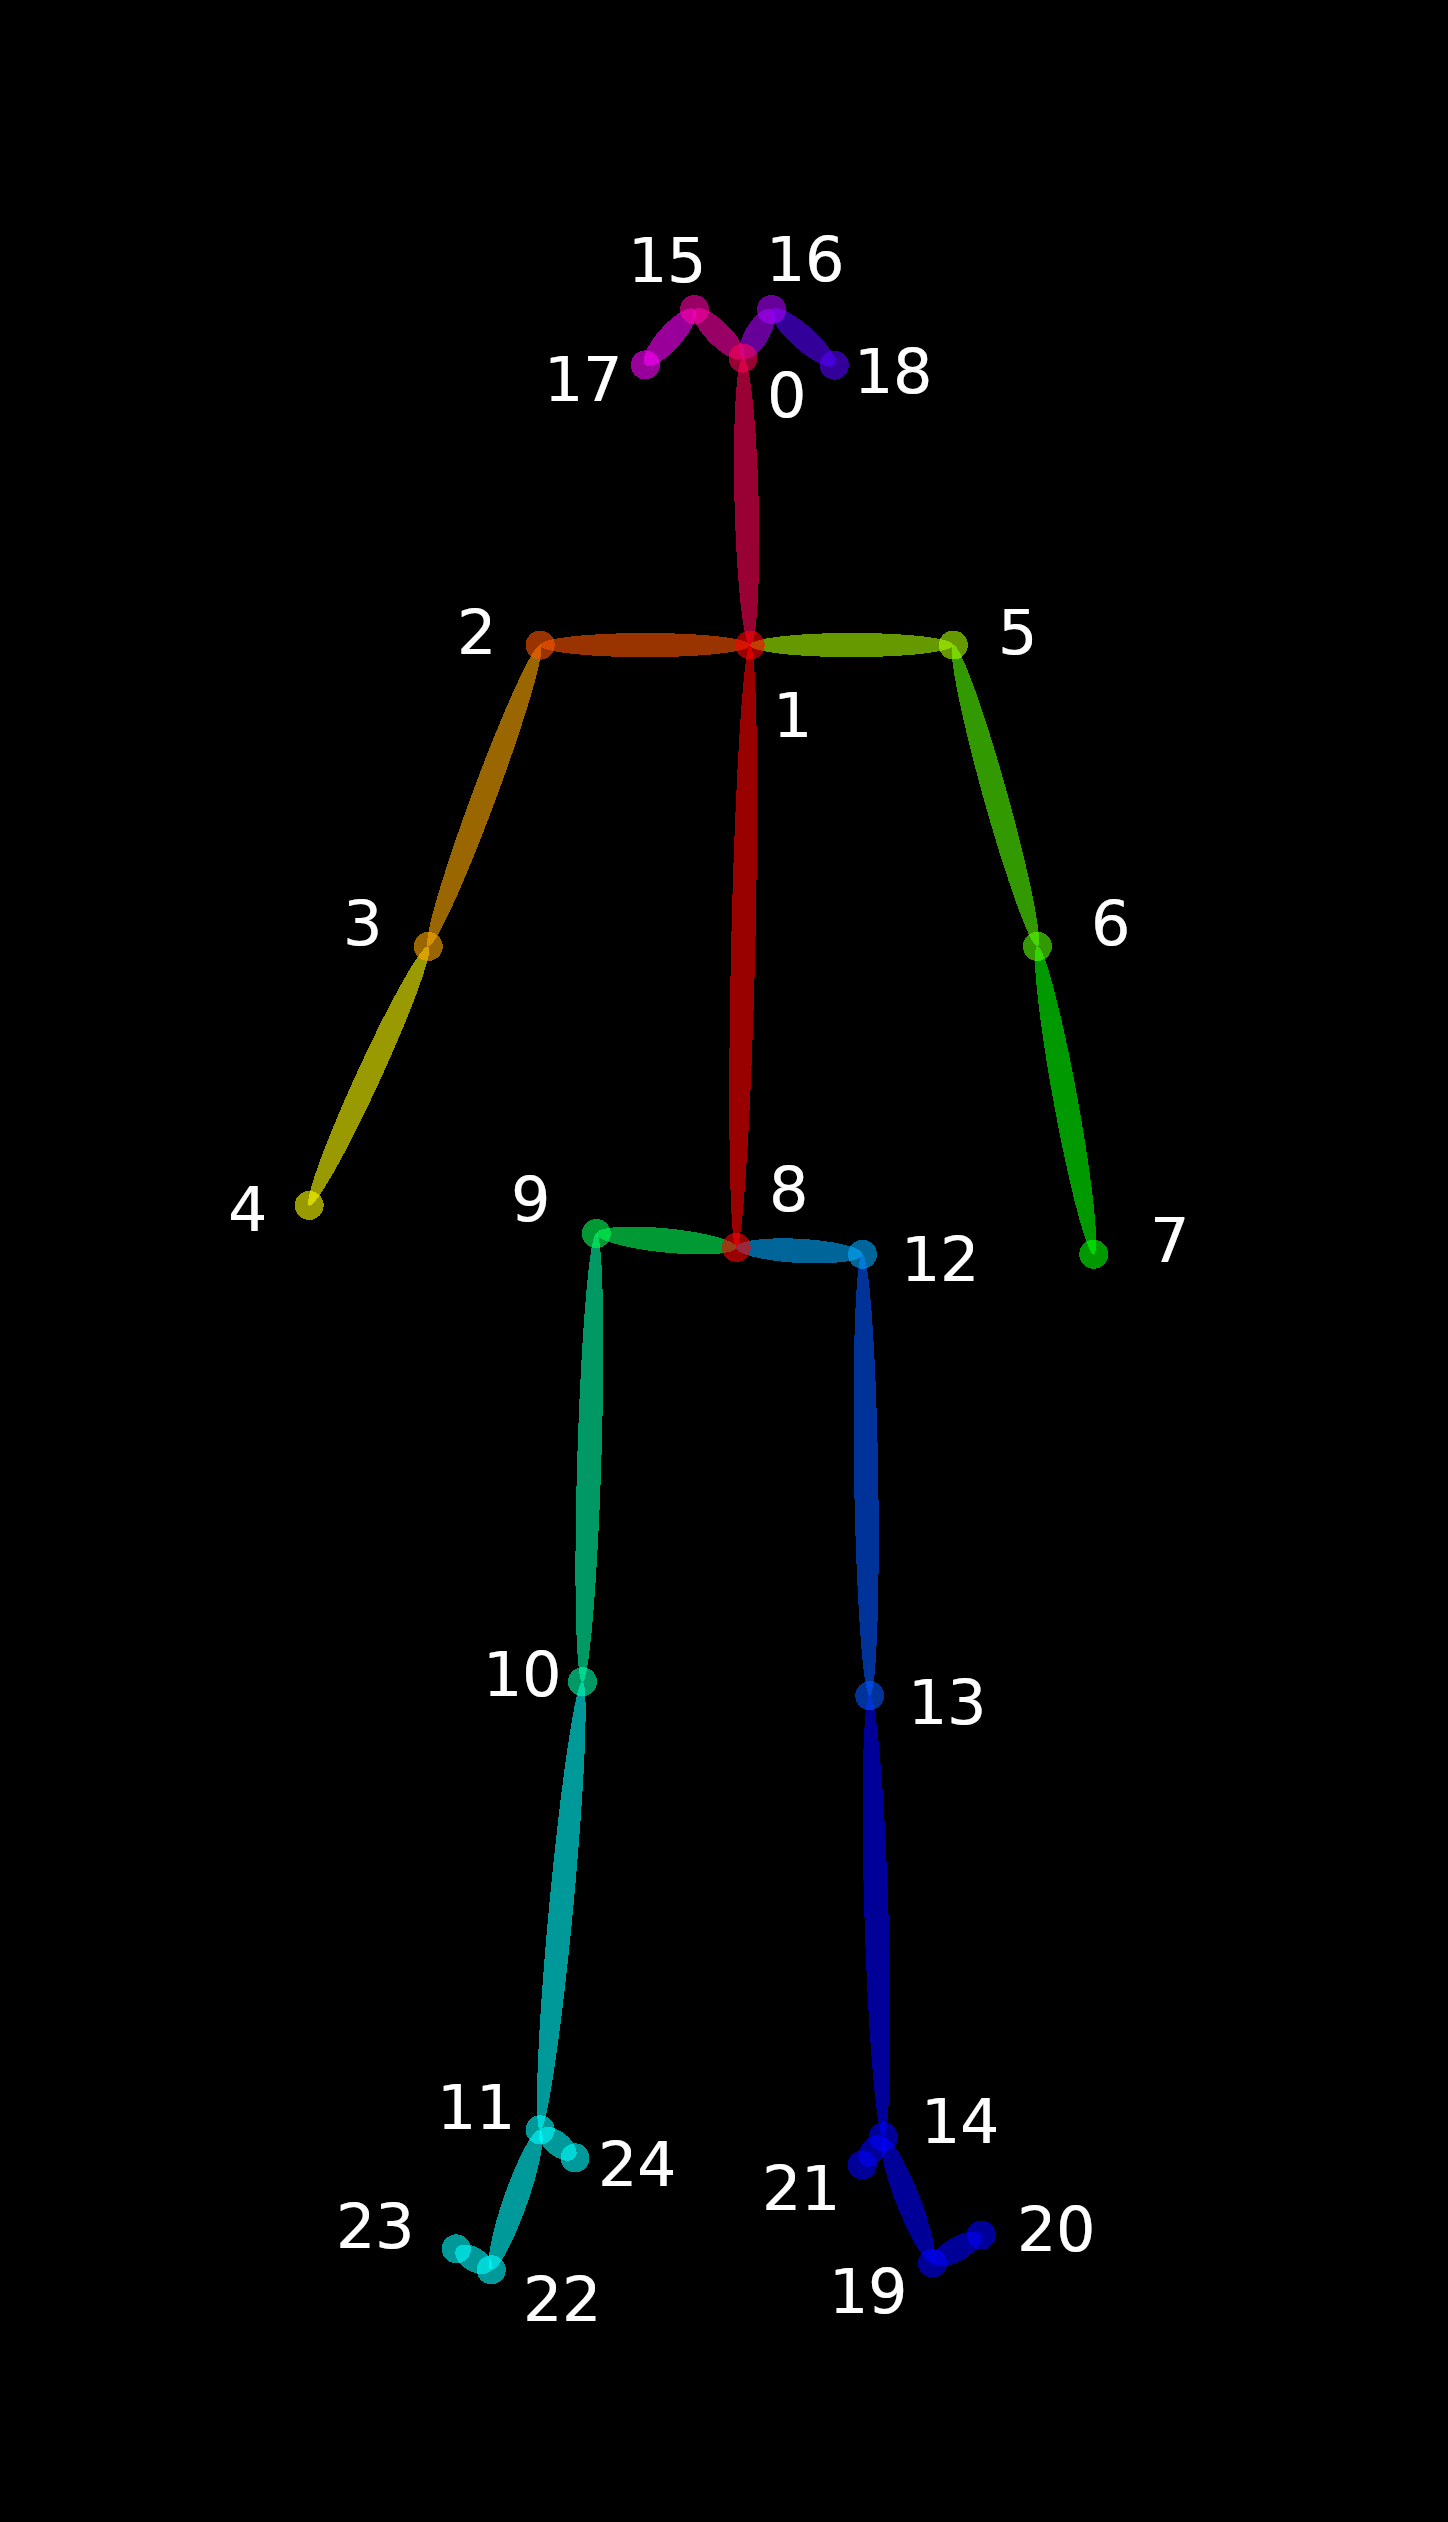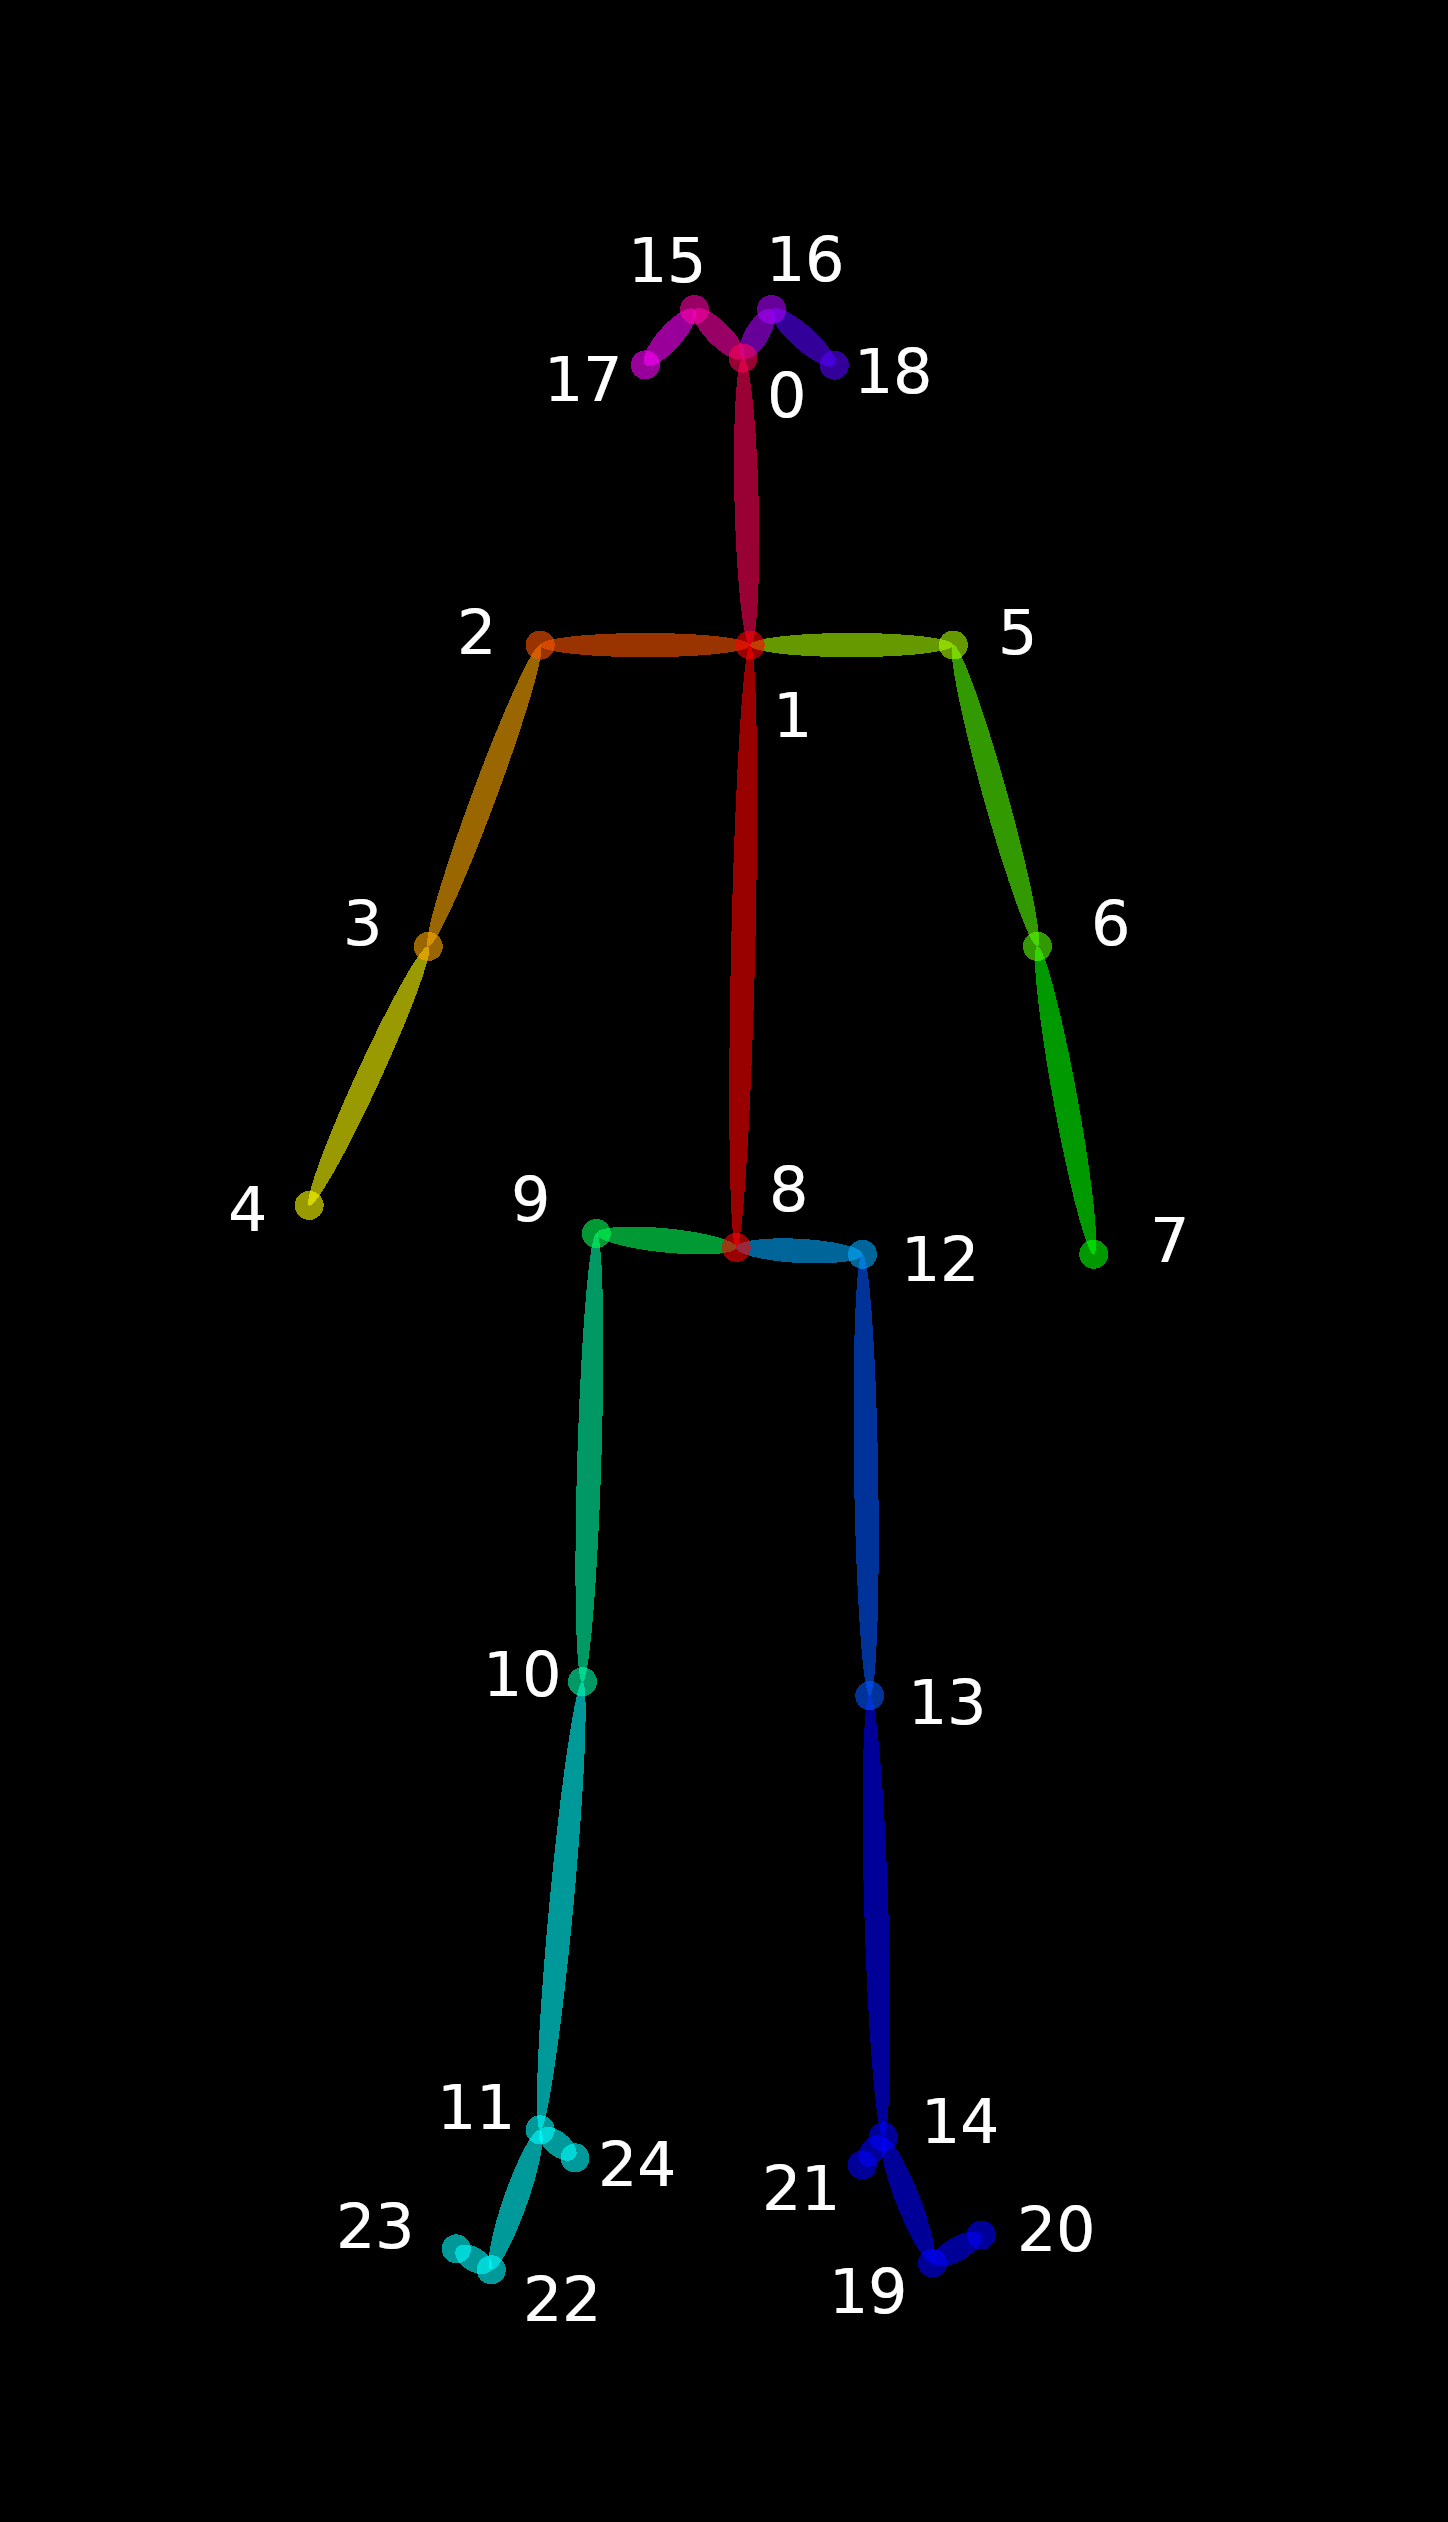)

BODY_25 의미


In [ ]:
temp=0
max_idx=0
#find frame number 
for i in range (0,len(ankle_list)):
  if max(ankle_list[i],temp)==ankle_list[i]:
    temp=ankle_list[i]
    max_idx=i
print(max_idx)
find_frame(max_idx)
